# Data_Table

In [2]:
set.seed(1212)
n <- 24
compounded <- rlnorm(n, meanlog = log(100), sdlog = 0.1)
generic    <- rlnorm(n, meanlog = log(95),  sdlog = 0.1)

In [3]:
log_comp <- log(compounded)
log_gen  <- log(generic)

In [4]:
mean_diff <- mean(log_gen) - mean(log_comp)
se_diff <- sqrt(var(log_gen)/n + var(log_comp)/n)

In [5]:
gmr <- exp(mean_diff)

# 90% CI

>  (z = 1.645 for two-sided 90% CI)

In [6]:
z <- 1.645
ci_lower <- exp(mean_diff - z * se_diff)
ci_upper <- exp(mean_diff + z * se_diff)

In [7]:
diff_raw <- mean(generic) - mean(compounded)

# Result

In [8]:
cat("GMR:", round(gmr, 2), "\n")
cat("90% CI:", round(ci_lower, 2), "~", round(ci_upper, 2), "\n")
cat("Difference (raw scale):", round(diff_raw, 2), "\n")
cat("SE (log scale):", round(se_diff, 4), "\n")

GMR: 0.93 
90% CI: 0.88 ~ 0.97 
Difference (raw scale): -7.56 
SE (log scale): 0.0311 


# Data_Figure

In [64]:
library(dplyr)
library(ggplot2)

In [65]:
set.seed(12123)

n_subjects <- 10
time_points <- c(0.5, 1, 2, 4, 6, 8)

subjects <- 1:n_subjects
seq_A <- sample(subjects, 5) 
seq_B <- setdiff(subjects, seq_A) 

generate_subject_data <- function(id, seq_group) {
  if (seq_group == "A") {
    data.frame(
      subject_id = id,
      period = rep(c(1, 2), each = length(time_points)),
      treatment = rep(c("Compounded", "Generic"), each = length(time_points)),
      time = rep(time_points, times = 2)
    )
  } else {
    data.frame(
      subject_id = id,
      period = rep(c(1, 2), each = length(time_points)),
      treatment = rep(c("Generic", "Compounded"), each = length(time_points)),
      time = rep(time_points, times = 2)
    )
  }
}

pk_df <- do.call(rbind, lapply(seq_A, function(id) generate_subject_data(id, "A")))
pk_df <- rbind(pk_df, do.call(rbind, lapply(seq_B, function(id) generate_subject_data(id, "B"))))

pk_df$conc <- with(pk_df, rlnorm(nrow(pk_df),
                                 meanlog = ifelse(treatment == "Compounded",
                                                  log(50 - 5 * time),
                                                  log(48 - 5 * time)),
                                 sdlog = 0.2))

In [66]:
options(repr.plot.width = 10, repr.plot.height = 6)

In [67]:
p <- ggplot(pk_df %>% filter(subject_id == 1), 
       aes(x = time, y = conc, color = treatment)) +
  geom_line(alpha = 0.8, linewidth = 1.2) +
  geom_point(size = 3) +
  labs(title = "Spaghetti Plot of PK Profile (Subject 1)",
       x = "Time (hr)", y = "Concentration (ng/mL)", color = "Treatment") +
  theme_minimal() +
  theme(
    legend.position = c(0.85, 0.9),
    legend.background = element_rect(fill = "white", color = "gray80"),
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 9)
  )

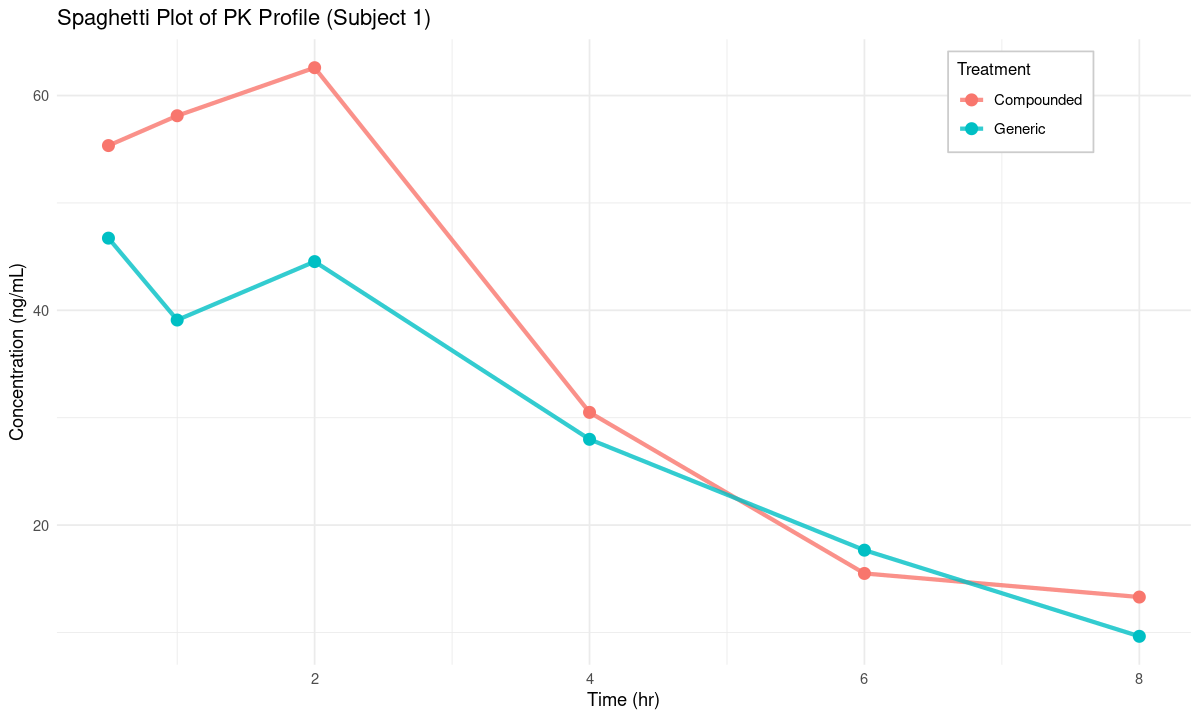

In [68]:
p

In [69]:
# ggsave("subject1_pk_plot.png", plot = p, width = 10, height = 6, dpi = 300)

In [70]:
options(repr.plot.width = 8, repr.plot.height = 8)

In [72]:
compute_auc <- function(time, conc) {
  sum(diff(time) * (head(conc, -1) + tail(conc, -1)) / 2)
}

auc_df <- pk_df %>%
  group_by(subject_id, period, treatment) %>%
  summarise(
    AUC = compute_auc(time, conc),
    .groups = "drop"
  ) %>%
  mutate(log_AUC = log(AUC))

In [76]:
p <- ggplot(auc_df, aes(x = treatment, y = log_AUC, fill = treatment)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "Log-transformed AUC by Treatment",
       x = "Treatment", y = "log(AUC)") +
  theme_minimal() +
  theme(legend.position = "none")

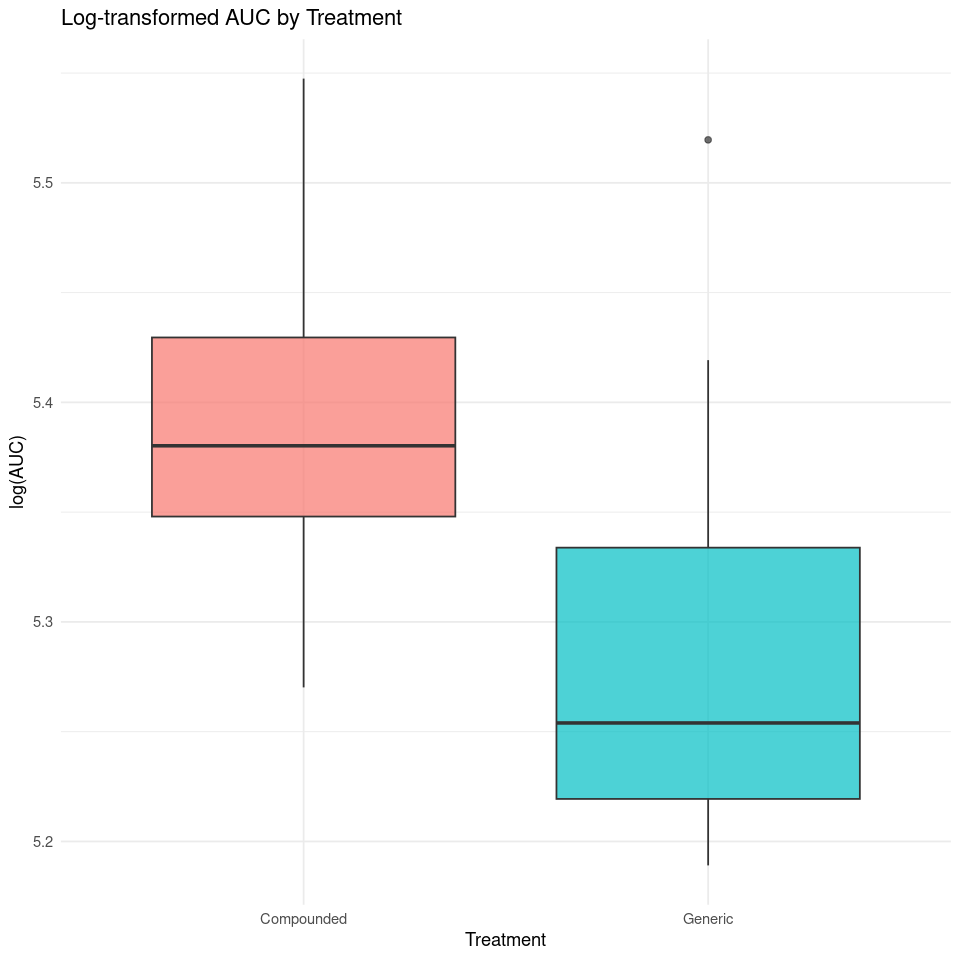

In [78]:
p

In [80]:
# ggsave("auc_plot.png", plot = p, width = 8, height = 8, dpi = 300)

# Reference

[[1]](https://www.researchgate.net/figure/Bioequivalence-calculations-for-log-trans-formed-values-of-AUC-and-C-MAX-for-comparison_tbl3_259764867) PK Table Example

[[2]](https://www.researchgate.net/figure/Box-plots-for-the-comparison-of-individual-plasma-trazpiroben-AUC-a-and-Cmax-b-for_fig3_358886907) AUC, Cmax Boxplot